# Liver Segmentation: All Stage Training

Train a deep learning neural network using both early-, intermediate, and advanced-stage HCC cancer subjects. 
In this case, early- and intermediate stage subjects were take to be those with BCLC stages 0, A, and B, and advanced stage disease was BCLC C and D.
We then evaluate the model on data that spans the full spectrum of cancer stages, in this case BCLC 0, A, B, C, and D.
This experiment uses n=220 images from Yale that were segmented by M. Gross on arterial phase T1 MRI.
This model uses PyTorch and the MONAI framework. 


In [1]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import torch
import time
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent
from monai.data import list_data_collate
from monai.networks.layers import Norm

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance

# Import the network
import sys
sys.path.append('../')
import network
import utils

monai.config.print_config()

MONAI version: 0.3.0rc3
Python version: 3.8.3 (default, May 19 2020, 18:47:26)  [GCC 7.3.0]
Numpy version: 1.19.2
Pytorch version: 1.5.1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.0
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: 1.15.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0a0+35d732a
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Verify System Setup
Check torch and CUDA on the system.

In [2]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [3]:
INPUT_PATH = r'../../data/experiment2_all_stage.csv'

df = pd.read_csv(INPUT_PATH, index_col=False)
df.drop_duplicates(inplace=True)
df = df[['IMAGE','SEGM','BCLC-2011','DATA_SPLIT']]

print('Dataset contains %d entries' % len(df))
df.head(5)

Dataset contains 201 entries


,IMAGE,SEGM,BCLC-2011,DATA_SPLIT
0,/tensor5/data1/LIVER/Yale/imaging/nifti/130131...,/data1/LIVER/Yale/segm/mask_nifti/13013150/liv...,1,Training
1,/tensor5/data1/LIVER/Yale/imaging/nifti/E10545...,/data1/LIVER/Yale/segm/mask_nifti/E105459652/l...,0,Training
2,/tensor5/data1/LIVER/Yale/imaging/nifti/114471...,/home/mgross/liver_segs_centered_and_revised/1...,2,Training
3,/tensor5/data1/LIVER/Yale/imaging/nifti/993330...,/data1/LIVER/Yale/segm/mask_nifti/9933309/live...,1,Training
4,/tensor5/data1/LIVER/Yale/imaging/nifti/123588...,/data1/LIVER/Yale/segm/mask_nifti/12358811/liv...,1,Training


In [4]:
print(df.groupby('DATA_SPLIT')['BCLC-2011'].value_counts().sort_index())

df_train = df[df['DATA_SPLIT']=='Training']
df_val = df[df['DATA_SPLIT']=='Validation']
df_test = df[df['DATA_SPLIT']=='Testing']

DATA_SPLIT  BCLC-2011
Testing     0             5
            1            17
            2             5
            3             7
            4            10
Training    0            19
            1            74
            2            18
            3             8
            4            10
Validation  0             4
            1            19
            2             5
Name: BCLC-2011, dtype: int64


In [5]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

print('Number of training files: ', len(train_data_dict))
print('Number of validation files: ', len(val_data_dict))
print('Number of testing files: ', len(test_data_dict))

Number of training files:  129
Number of validation files:  28
Number of testing files:  44


## Setup Input Transformations

In [6]:
SPACING = (2.0,2.0,2.0)

train_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=(64,64,32), mode=('reflect','reflect'), ),
    # randomly crop out patch samples from big image based on pos / neg ratio
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=(64,64,32), pos=3, neg=1, num_samples=2),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadNiftid(keys=['IMAGE', 'SEGM']),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    ToTensord(keys=['IMAGE', 'SEGM'])
])



## Check Input Data

torch.Size([1, 1, 211, 152, 135])
image shape: torch.Size([211, 152, 135]), label shape: torch.Size([211, 152, 135])
image mean: 0.12479522079229355


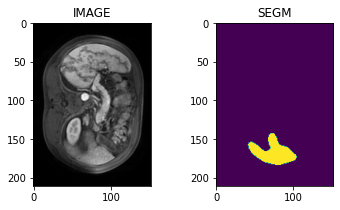

In [7]:
# check_ds = monai.data.Dataset(data=train_data_dict[:3], transform=train_transforms)
# check_ds = monai.data.Dataset(data=val_data_dict[:1], transform=val_transforms)
check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create a Persistent Data Cache for Training/Validation/Test Data

In [8]:
CACHE_PATH = r'monai_cache'

In [9]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [10]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [11]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Create Segmentation Model (U-net)

In [12]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = network.MRILiverSegmentation().to(device)
summary(model, (1,64,64,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 32, 16]             448
            Conv3d-2       [-1, 16, 32, 32, 16]             448
       BatchNorm3d-3       [-1, 16, 32, 32, 16]              32
             PReLU-4       [-1, 16, 32, 32, 16]               1
            Conv3d-5       [-1, 16, 32, 32, 16]           6,928
       BatchNorm3d-6       [-1, 16, 32, 32, 16]              32
             PReLU-7       [-1, 16, 32, 32, 16]               1
      ResidualUnit-8       [-1, 16, 32, 32, 16]               0
            Conv3d-9        [-1, 32, 16, 16, 8]          13,856
           Conv3d-10        [-1, 32, 16, 16, 8]          13,856
      BatchNorm3d-11        [-1, 32, 16, 16, 8]              64
            PReLU-12        [-1, 32, 16, 16, 8]               1
           Conv3d-13        [-1, 32, 16, 16, 8]          27,680
      BatchNorm3d-14        [-1, 32, 16

## Train the Model Using Lightning Training Loop

In [13]:
MODEL_ROOT_PATH = r'../../saved_models/ex2'

In [ ]:
# initialise the LightningModule
model = network.MRILiverSegmentation()

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

checkpoint_callback = pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint(
    filepath=os.path.join(MODEL_ROOT_PATH, 'saved_model',"{epoch}-{val_dice:.2f}"),
    save_last=True,
    save_top_k=2,
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=500,
    logger=tb_logger,
    checkpoint_callback=checkpoint_callback,
    show_progress_bar=False,
    num_sanity_val_steps=0,
    check_val_every_n_epoch=10,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
# IPython.display.clear_output()

## Model Evaluation


In [14]:
# Load 
checkpoint = torch.load(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt'))

model = network.MRILiverSegmentation()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Inference on Training Data

In [15]:
train_infer_ds = monai.data.Dataset(
    data=train_data_dict, transform=test_transforms
)
train_infer_loader = DataLoader(train_infer_ds, batch_size=1, num_workers=4)

df_results_train = utils.evaluate(model=model, data_loader=train_infer_loader)
df_results_train.describe()


0it [00:00, ?it/s]

/home/jonofrey/anaconda3/envs/monai/lib/python3.8/site-packages/monai/metrics/meandice.py:209: UserWarning: y_pred has only one channel, include_background=False ignored.
  warnings.warn("y_pred has only one channel, include_background=False ignored.")


,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,0.951814,0.960083,15.290818,2.386046,3.155283,0.655610,0.655610
std,0.023360,0.011206,20.284821,2.265842,4.366204,0.315131,0.315131
min,0.776341,0.910149,1.414214,1.414214,0.426737,0.405466,0.405466
25%,0.946509,0.955099,2.000000,1.732051,0.827146,0.524287,0.524287
50%,0.956966,0.962772,2.449490,2.000000,1.357560,0.609742,0.609742
75%,0.964742,0.967512,28.904151,2.449490,3.559184,0.695687,0.695687
max,0.978501,0.979011,80.164830,25.298221,26.024026,3.774324,3.774324


In [16]:
df_results_train.to_csv('AS-Net_Results_Training.csv', index=False)

### Inference on Validation Data

In [17]:
df_results_val = utils.evaluate(model=model, data_loader=val_loader)
df_results_val.describe()

0it [00:00, ?it/s]

/home/jonofrey/anaconda3/envs/monai/lib/python3.8/site-packages/monai/metrics/meandice.py:209: UserWarning: y_pred has only one channel, include_background=False ignored.
  warnings.warn("y_pred has only one channel, include_background=False ignored.")


,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,0.914011,0.924932,15.082988,5.349333,4.162228,1.206236,1.206236
std,0.142164,0.156296,20.313615,9.334094,6.432343,1.727150,1.727150
min,0.233595,0.133062,1.414214,1.414214,0.521821,0.472805,0.472805
25%,0.943061,0.952273,2.177051,2.000000,0.983629,0.539896,0.539896
50%,0.954058,0.958742,3.000000,2.236068,1.441224,0.692230,0.692230
75%,0.961502,0.965504,27.184906,3.079156,4.351283,0.869316,0.869316
max,0.974392,0.974695,67.889616,46.086874,26.175416,9.126712,9.126712


In [18]:
df_results_val.to_csv('AS-Net_Results_Validation.csv', index=False)

### Inference on Test Data

In [19]:
OUTPUT_PATH = os.path.join(MODEL_ROOT_PATH,'results')

df_results_test = utils.evaluate(model=model, data_loader=test_loader)
df_results_test.describe()

0it [00:00, ?it/s]

/home/jonofrey/anaconda3/envs/monai/lib/python3.8/site-packages/monai/metrics/meandice.py:209: UserWarning: y_pred has only one channel, include_background=False ignored.
  warnings.warn("y_pred has only one channel, include_background=False ignored.")


,DICE,POST_DICE,HD95,POST_HD95,MAD,POST_MAD,InferenceTime
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.947805,0.953664,16.989172,3.500261,2.710190,0.750125,0.750125
std,0.026278,0.018455,19.554896,4.033337,2.848960,0.370064,0.370064
min,0.820215,0.899152,1.414214,1.414214,0.436969,0.436969,0.436969
25%,0.941119,0.946443,2.236068,2.000000,0.750245,0.579927,0.579927
50%,0.953674,0.960306,4.182873,2.236068,1.430524,0.625914,0.625914
75%,0.963260,0.966649,32.282365,3.000000,3.690852,0.764092,0.764092
max,0.974429,0.975951,86.406018,24.690072,11.974038,2.543459,2.543459


In [20]:
df_results_test.to_csv('AS-Net_Results_Testing.csv', index=False)